# Overview
This notebook applies some basic signal processing techniques to the bird sounds dataset for classification. 

## Extract
- Choose a cutoff minimum duration $s$. This will be the common duration for all the samples 
- Extract the signal and the sample rate for each sample
- For now just truncate to the middle $s$ seconds for each sample
- Resample to a common rate
- Save the signals and the labels to a dataset

## Transform
- Apply framing and windowing
- Apply the DTFT to produce the spectrogram
- Design a noise filter
- Normalize the spectrograms

## Train 
- Use a Tensorflow dataset to flow from the persisted dataset and apply the transformations
- Train a CNN model

# Imports

In [10]:
import librosa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import tensorflow as tf
import h5py
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
import math
from scipy.io.wavfile import write

In [2]:
# Make sure GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Exploratory Data Analysis
Here we will explore some basic properties of the dataset and choose a value for $s$ that makes sense based on the data.

In [3]:
metadata = pd.read_csv('/data/recordings.csv')
metadata.head()

id     gen        sp  ssp  group           en           rec  \
0  936105  Branta  bernicla  NaN  birds  Brant Goose   Arjun Dutta   
1  934302  Branta  bernicla  NaN  birds  Brant Goose   Mats Olsson   
2  906056  Branta  bernicla  NaN  birds  Brant Goose    Juha Saari   
3  898133  Branta  bernicla  NaN  birds  Brant Goose    Paul Kelly   
4  882013  Branta  bernicla  NaN  birds  Brant Goose  Jean COURTIN   

              cnt                                                loc      lat  \
0  United Kingdom  Great Britain (near  Wallington), Greater Lond...  51.3532   
1          Sweden              Dalgången 23, Karlshamn, Blekinge län      NaN   
2         Finland                     Pihlajamäki, Helsinki, Uusimaa  60.2357   
3         Ireland          Tacumshin Lake (East End), County Wexford  52.1963   
4          France  Arrondissement de Vannes (near  Sérent), Morbi...  47.7981   

   ...  bird-seen animal-seen playback-used temp regnr auto  \
0  ...         no          no            no  NaN   NaN   no   
1  ...         no          no            no  NaN   NaN   no   
2  ...         no          no            no  NaN   NaN  yes   
3  ...         no          no            no  NaN   NaN  yes   
4  ...        yes         yes            no  NaN   NaN  yes   

                  dvc            mic    smp  label  
0       Tascam DR-05x            NaN  44100  goose  
1  Wildlife Acoustics            NaN  24000  goose  
2                 NaN  Telinga PRO-X  44100  goose  
3                 SM4           SM4   44100  goose  
4                 NaN            NaN  44100  goose  

[5 rows x 39 columns]

In [4]:
# Extract timestamps
metadata['length'] = metadata['length'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

# Create dictionary of id to label
label_dict = dict(zip(metadata['id'], metadata['label']))

In [5]:
metadata['length'].describe()

count    7006.000000
mean       42.353697
std        84.070134
min         0.000000
25%        10.000000
50%        21.000000
75%        45.000000
max      1800.000000
Name: length, dtype: float64

In [6]:
metadata[metadata['length'] > 10]['label'].value_counts()

label
hawk     2044
heron    1664
goose    1455
Name: count, dtype: int64

In [7]:
def plot_signal(signal, fs, title):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(signal, sr=fs)
    plt.title(title)

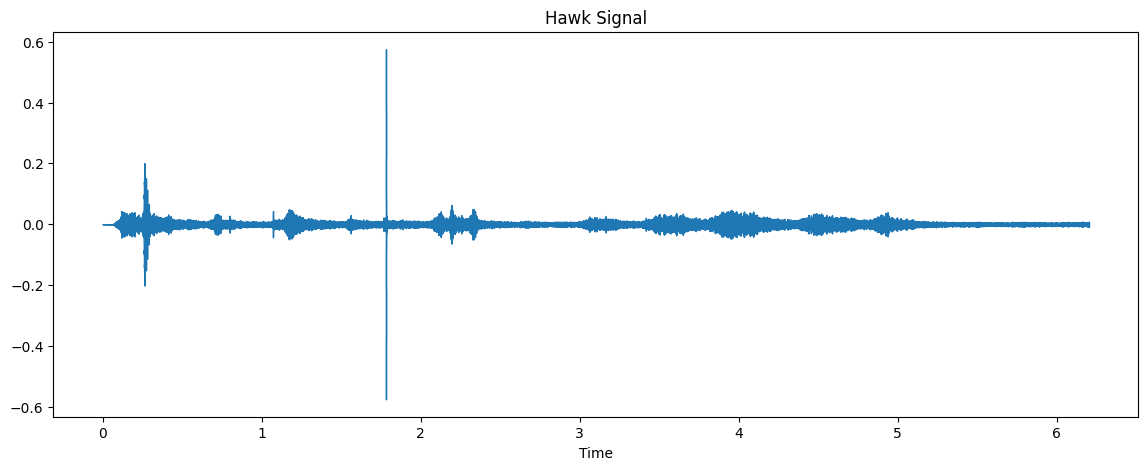

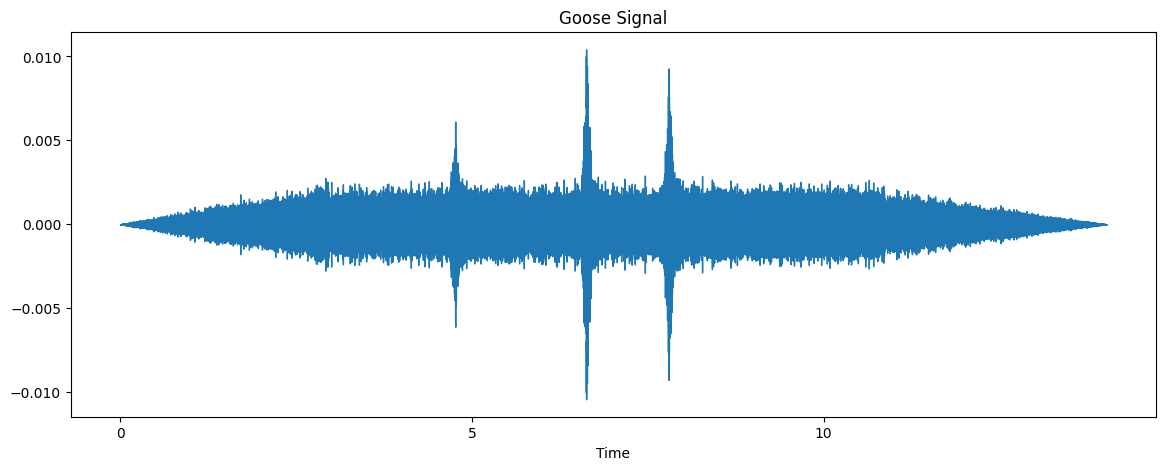

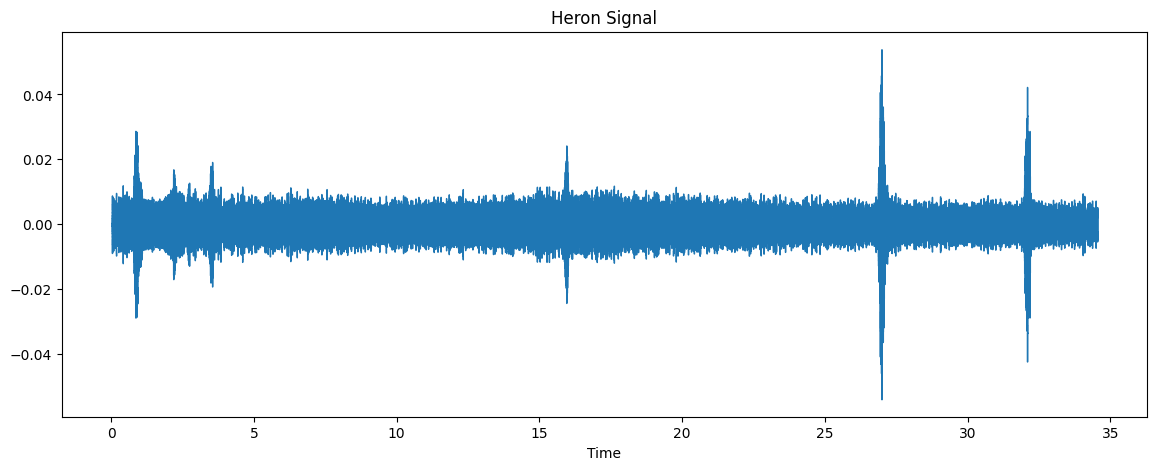

In [8]:
# Load signal and sample rate
hawk_signal, hawk_fs = librosa.load('/data/recordings/hawk_211230.mp3', sr=None)
goose_signal, goose_fs = librosa.load('/data/recordings/goose_678800.mp3', sr=None)
heron_signal, heron_fs = librosa.load('/data/recordings/heron_268502.mp3', sr=None)

# Plot signal
plot_signal(hawk_signal, hawk_fs, 'Hawk Signal')
plot_signal(goose_signal, goose_fs, 'Goose Signal')
plot_signal(heron_signal, heron_fs, 'Heron Signal')

# Extract
Here we will:
- Load the data using `librosa`
- Truncate to extract the middle $s$ seconds
- Resample to a common sample rate
- Save the signals and labels to a file

In [9]:
def extract_middle(signal, fs, duration_seconds=10):
    duration_samples = duration_seconds * fs
    signal_length = len(signal)
    start = (signal_length - duration_samples) // 2
    end = start + duration_samples
    return signal[start:end]

def load_batch(batch, duration_seconds=10, target_fs=16000):
    signals = []
    labels = []
    ids = []
    for i, file in enumerate(batch):
        # Check that file exists
        if not os.path.exists(f'/data/recordings/{file}'):
            print(f'Skipping {file} due to missing file')
            continue
        signal, fs = librosa.load(f'/data/recordings/{file}', sr=None)
        signal = extract_middle(signal, fs, duration_seconds)
        if len(signal) != duration_seconds * fs:
            print(f'Skipping {file} due to incorrect duration')
            continue
        signal = librosa.resample(signal, orig_sr=fs, target_sr=target_fs)
        signals.append(signal)
        file_name = file.split('_')
        labels.append(file_name[0])
        ids.append(int(file_name[1].split('.')[0]))
    return np.array(signals), np.array(ids), np.array(labels)

def save_batch(batch, save_path, dataset_name='signals'):
    with h5py.File(save_path, 'a') as f:
        if dataset_name in f:
            dataset = f[dataset_name]
            dataset.resize(dataset.shape[0] + batch.shape[0], axis=0)
            dataset[-batch.shape[0]:] = batch
        else:
            maxshape = (None,) + batch.shape[1:]
            f.create_dataset(dataset_name, data=batch, maxshape=maxshape, chunks=True)

def get_batches(file_list, batch_size):
    for i in range(0, len(file_list), batch_size):
        yield file_list[i:i + batch_size]

def extract_signals(file_list, save_path, ohe, duration_seconds=10, batch_size=32, target_fs=16000):
    for i, batch_files in enumerate(get_batches(file_list, batch_size)):
        signals, ids, labels = load_batch(batch_files, duration_seconds, target_fs)
        labels = ohe.transform(labels.reshape(-1, 1)).toarray()
        save_batch(signals, save_path, f'signals_{duration_seconds}s_{target_fs}hz')
        save_batch(labels, save_path, 'labels')
        save_batch(ids, save_path, 'ids')
        print(f'Saved {len(batch_files)} signals for batch {i}')

In [10]:
signals, ids, labels = load_batch(['hawk_531031.mp3'], duration_seconds=10, target_fs=16000)

In [11]:
signals[0]
write('/data/test.wav', 16000, signals[0])

In [12]:
signal, fs = librosa.load(f'/data/recordings/hawk_531031.mp3', sr=None)
middle_signal = extract_middle(signal, fs, 10)
write('/data/test.wav', fs, middle_signal)

In [13]:
metadata['file_path'] = metadata[['id', 'label']].apply(lambda x: f'{x[1]}_{x[0]}.mp3', axis=1)
files = metadata[metadata['length'] > 10]['file_path'].values
len(files)

/tmp/ipykernel_32000/2003793498.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metadata['file_path'] = metadata[['id', 'label']].apply(lambda x: f'{x[1]}_{x[0]}.mp3', axis=1)


5163

In [99]:
ohe = OneHotEncoder().fit(np.array(['hawk', 'heron', 'goose']).reshape(-1, 1))
# extract_signals(files, '/data/bird_sounds.h5', ohe, duration_seconds=10, batch_size=64, target_fs=16000)

In [15]:
# Train test split
def split_dataset(file_path, dataset_name, train_ratio=0.8):
    with h5py.File(file_path, 'r+') as f:
        data = f[dataset_name][:]
        data_len = len(data)
        indices = np.arange(data_len)
        np.random.shuffle(indices)
        train_size = int(train_ratio * data_len)
        train_indices = indices[:train_size]
        test_indices = indices[train_size:]
        
        # Split the data into train and test sets
        train_data = data[train_indices]
        test_data = data[test_indices]

        f.create_dataset(f'{dataset_name}_train', data=train_data)
        f.create_dataset(f'{dataset_name}_test', data=test_data)

In [ ]:
# split_dataset('/data/bird_sounds.h5', 'signals_10s_16000hz', train_ratio=0.8)

In [17]:
# Load a single signal from the dataset
def load_dataset(file_path, indices, duration_seconds=10, target_fs=16000):
    with h5py.File(file_path, 'r') as f:
        signals = f[f'signals_{duration_seconds}s_{target_fs}hz'][indices]
        labels = f['labels'][indices]
        ids = f['ids'][indices]
    return signals, labels, ids

In [18]:
signals, labels, ids = load_dataset('/data/bird_sounds.h5', slice(0, 20))

In [19]:
# Listen to the first signal
write('/data/test.wav', 16000, signals[0, :])

## Transform
Here we will build a TensorFlow dataset that reads from the saved file in batches and applies the following transformations:
- Framing
- Windowing (using a Hamming function)
- FFT (real-valued) to produce the spectrogram
- Take the log magnitude of the spectrum
- Normalize

In [265]:
# Generator function to load batches of data from HDF5
def data_generator(fname, batch_size, dataset_name, labels_name):
    with h5py.File(fname, "r") as f:
        data = f[dataset_name]
        labels = f[labels_name]
        num_samples = data.shape[0]
        
        while True:
            for i in range(0, num_samples, batch_size):
                batch_data = data[i : i + batch_size]
                batch_labels = labels[i : i + batch_size]
                yield batch_data, batch_labels

# Create dataset from generator
def get_tf_dataset(fname, batch_size, dataset_name, labels_name):
    generator = lambda: data_generator(fname, batch_size, dataset_name, labels_name)
    data_shape = h5py.File(fname, "r")[dataset_name].shape[1:]
    label_shape = h5py.File(fname, "r")[labels_name].shape[1:]
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *data_shape), dtype=tf.float32),
            tf.TensorSpec(shape=(None, *label_shape), dtype=tf.float32),
        ),
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
def build_signal_dataset(dataset, batch_size, frame_size = 1024, step_size = 512):
    window = tf.signal.hamming_window(frame_size)
    
    # Framing
    dataset = dataset.map(
        lambda signals, labels: (tf.signal.frame(signals, frame_size, step_size), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Windowing
    dataset = dataset.map(
        lambda signals, labels: (signals * window, labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Real-valued Fourier Transform
    dataset = dataset.map(
        lambda signals, labels: (tf.abs(tf.signal.rfft(signals)), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Centering
    dataset = dataset.map(
        lambda signals, labels: (signals - tf.reduce_mean(signals, axis=(1, 2), keepdims=True), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Log-magnitude
    dataset = dataset.map(
        lambda signals, labels: (tf.math.log(signals + 1e-6), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Normalization
    dataset = dataset.map(
        lambda signals, labels: (tf.math.divide(signals, tf.reduce_max(signals)), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [28]:
def compute_input_size(sample_rate, duration_seconds, frame_size, step_size):
    signal_length = sample_rate * duration_seconds
    
    # Compute the number of frames
    num_frames = math.floor((signal_length - frame_size) / step_size) + 1
    
    # Compute the number of frequency bins
    frequency_bins = frame_size // 2 + 1
    
    return num_frames, frequency_bins

## Testing Transformation Pipeline

In [226]:
sample_rate = 16000 # Resample to 16kHz
frame_size = int(0.05 * sample_rate)
step_size = frame_size // 4 # 25% overlap 
batch_size = 32

In [227]:
dataset_generator = data_generator('/data/bird_sounds.h5', batch_size, 'signals_10s_16000hz', 'labels')

In [228]:
signals, labels = next(dataset_generator)
signals.shape, labels.shape

((32, 160000), (32, 3))

In [272]:
with h5py.File('/data/bird_sounds.h5', 'r') as f:
    all_labels = f['labels'][:]

num_geese = 1453
num_hawks = 2042
num_herons = 1658

sum(all_labels)

array([1453., 2042., 1658.])

In [229]:
def get_signals(indices):
    with h5py.File('/data/bird_sounds.h5', 'r') as f:
        signals = f['signals_10s_16000hz'][indices]
        labels = f['labels'][indices]
    return signals, labels


In [296]:
chosen_goose, _ = get_signals(range(3, 4))
chosen_hawk, _ = get_signals(range(num_geese + 2, num_geese + 3))
chosen_heron, _ = get_signals(range(num_geese + num_hawks + 7, num_geese + num_hawks + 8))

In [297]:
write('/data/sounds/goose.wav', 16000, chosen_goose[0])
write('/data/sounds/hawk.wav', 16000, chosen_hawk[0])
write('/data/sounds/heron.wav', 16000, chosen_heron[0])

In [290]:
num_samples = 32

In [291]:
goose_signals, _ = get_signals(range(num_samples))
hawk_signals, _ = get_signals(range(num_geese, num_geese + num_samples))
heron_signals, _ = get_signals(range(num_geese + num_hawks, num_geese+num_hawks+num_samples))

In [292]:
def process_data(signals, frame_size, step_size):
    window = tf.signal.hamming_window(frame_size)
    frames = tf.signal.frame(signals, frame_size, step_size)
    windowed = frames * window
    ft = tf.abs(tf.signal.rfft(windowed))
    mean_value = tf.reduce_mean(ft, axis=(1, 2), keepdims=True)
    ft = ft - mean_value
    ft = tf.math.log(tf.abs(ft) + 1e-6)
    ft = tf.math.divide(ft, tf.reduce_max(ft))
    return ft

goose_spectrograms = process_data(goose_signals, frame_size, step_size)
hawk_spectrograms = process_data(hawk_signals, frame_size, step_size)
heron_spectrograms = process_data(heron_signals, frame_size, step_size)

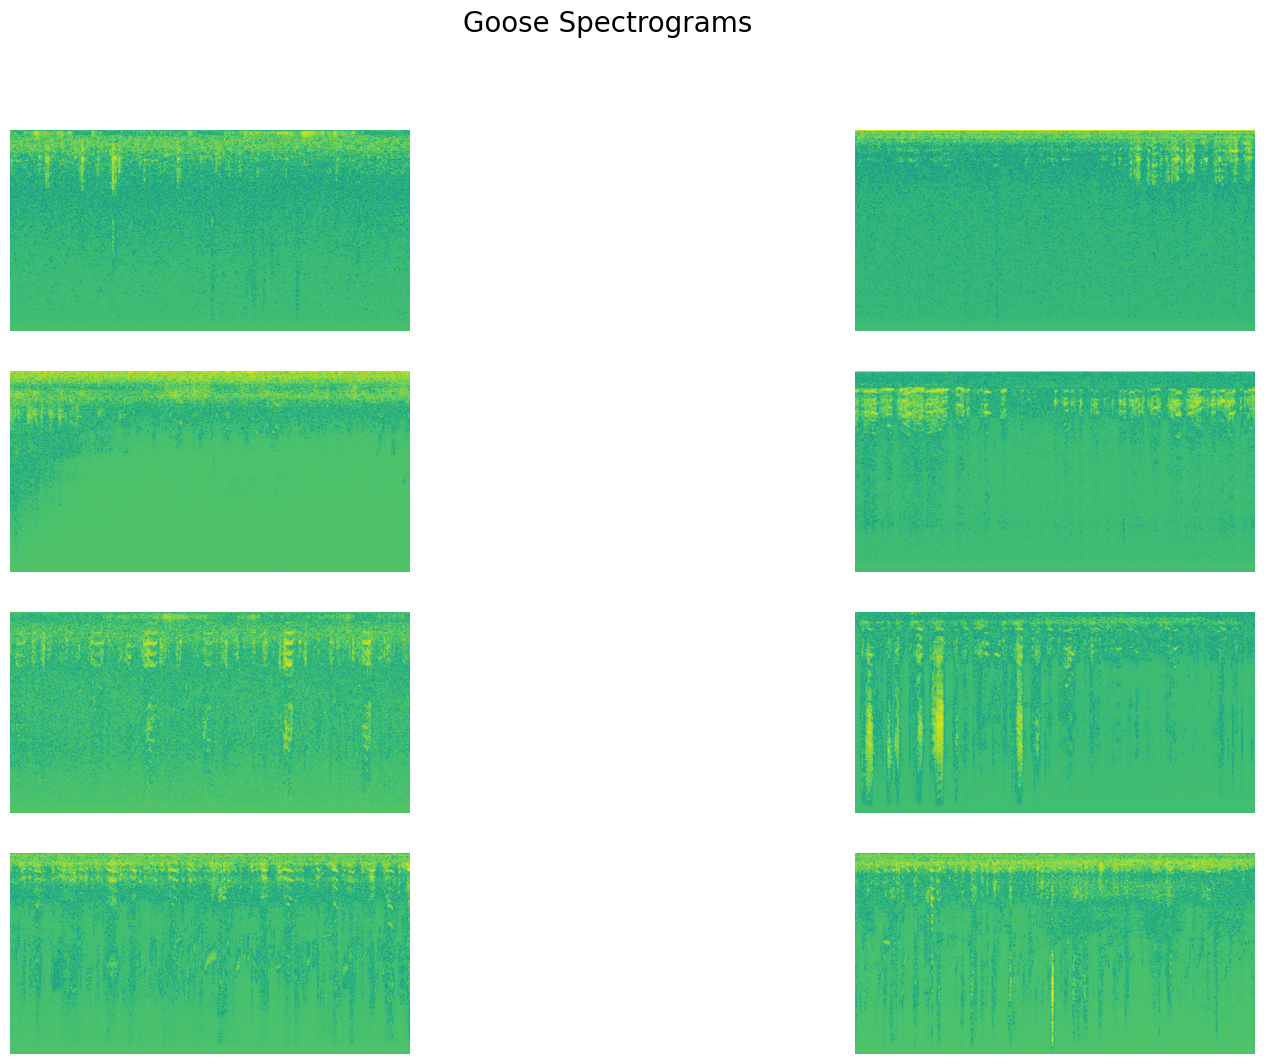

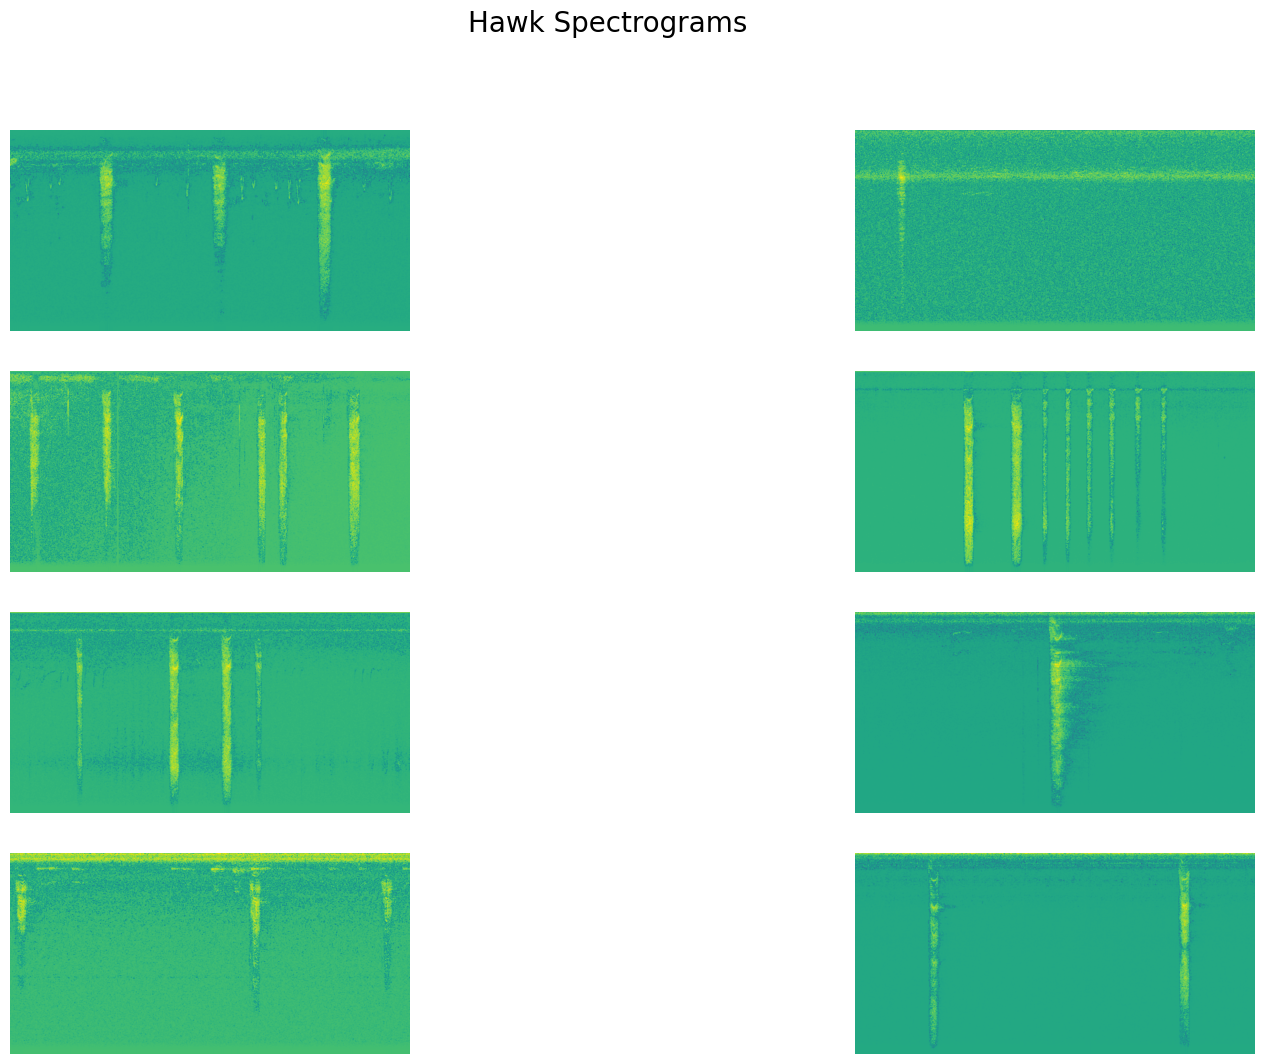

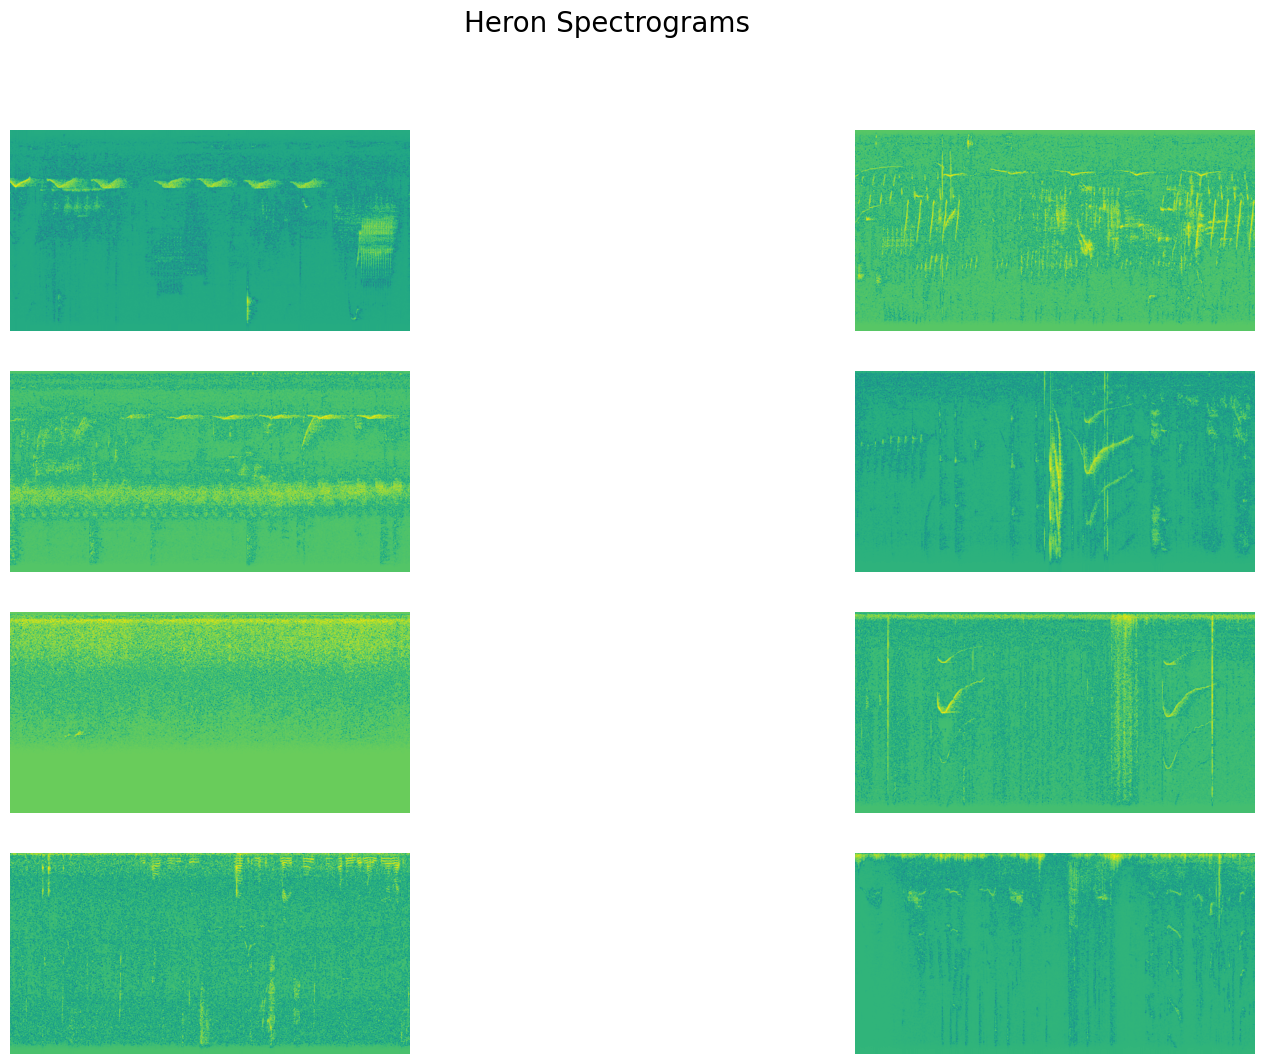

In [293]:
# Create three figures, each 4 rows and 8 columns
# Plot the spectrograms of the first 32 signals for each bird
def plot_spectrograms(spectrograms, title):
    fig, axs = plt.subplots(4, 2, figsize=(20, 12))
    fig.suptitle(title, fontsize=20)
    for i, ax in enumerate(axs.flat):
        ax.imshow(tf.transpose(spectrograms[i, :, :]))
        
        # Turn of axis labels
        ax.axis('off')
    plt.savefig(f'/data/spectrograms/{title}.png')

plot_spectrograms(goose_spectrograms, 'Goose Spectrograms')
plot_spectrograms(hawk_spectrograms, 'Hawk Spectrograms')
plot_spectrograms(heron_spectrograms, 'Heron Spectrograms')

# Train

In [302]:
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    return model

In [298]:
dataset = get_tf_dataset('/data/bird_sounds.h5', batch_size, 'signals_10s_16000hz', 'labels')

In [299]:
train = build_signal_dataset(dataset, batch_size, frame_size=frame_size, step_size=step_size)
# test = build_signal_dataset(test, batch_size, frame_size=frame_size, step_size=step_size)

In [300]:
num_frames, frequency_bins = compute_input_size(sample_rate, 10, frame_size, step_size)
model = build_model((num_frames, frequency_bins, 1), 3)

In [ ]:
# model.fit(dataset, epochs=1, batch_size=batch_size)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, None, 3), output.shape=(None, 3)

In [77]:
preds = model.evaluate(test, batch_size=batch_size)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.0000e+00 - loss: 2495.0806


2024-11-20 22:34:25.562064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17831868190020642002
/home/scientist/miniconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-20 22:34:25.562285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6293525115235299080
